# Reading CSV data

In [73]:
import csv
EDGES = []
with open('vk_links.csv') as csv_file:
    reader = csv.reader(csv_file)
    skip_first = 1
    for row in reader:
        if skip_first == 1:
            skip_first = 0
            continue
        EDGES.append((row[0],row[1]))
    
# Getting unique names
NAMES = set([x for t in EDGES for x in t])

In [74]:
# Debug
#print(EDGES)
#print(NAMES)

# Find out clusters in graph

In [75]:
import louvain      # pacaur -S igraph && sudo pip3 install louvain
import igraph as ig


# Creating igraph based on our data
graph = ig.Graph(directed=True)

# Adding vertices
for key in NAMES:
    graph.add_vertices(key)
    
# Adding edges
graph.add_edges(EDGES)

# Clustering data
partitions = louvain.find_partition(graph, louvain.ModularityVertexPartition)
print(partitions)
society = []
for idx in range(len(partitions)):
    society.append(partitions.subgraph(idx))

Clustering with 12 elements and 3 clusters
[0] olga, nina, rita, petr, ivan
[1] masha, dasha, nikita, pavel, ula
[2] vika, zara


# Rank users in societies

In [76]:
import numpy as np
from scipy.sparse import csc_matrix

def page_rank(graph, s=0.86, maxerr=0.001):
    """
    Page Rank algorithm for numpy adjacent matrix.
    
    
    """
    n = graph.shape[0]

    # transform G into markov matrix A
    A = csc_matrix(graph,dtype=np.float)
    rsums = np.array(A.sum(1))[:,0]
    ri, ci = A.nonzero()
    A.data /= rsums[ri]

    # bool array of sink states
    sink = rsums==0

    # Compute pagerank r until we converge
    ro, r = np.zeros(n), np.ones(n)
    while np.sum(np.abs(r-ro)) > maxerr:
        ro = r.copy()
        # calculate each pagerank at a time
        for i in range(0,n):
            # inlinks of state i
            Ai = np.array(A[:,i].todense())[:,0]
            # account for sink states
            Di = sink / float(n)
            # account for teleportation to state i
            Ei = np.ones(n) / float(n)

            r[i] = ro.dot( Ai*s + Di*s + Ei*(1-s) )

    # return normalized pagerank
    return r/float(sum(r))

def label_members(vs, ranks, k=0.2):
    """
    Label members from `vs' using `ranks' with accuracy `k'
    
    We get maximum values from ranks and label the accurate winners as "leaders".
    The accurate loosers are "followers".
    All the other are "agents".
    """
    max_val = ranks[0]
    min_val = ranks[0]
    max_idx = min_idx = 0
    nodes = {}
    for idx, val in enumerate(ranks): 
        max_val = max(val, max_val)
        if max_val == val: max_idx = idx
        min_val = min(val, min_val)
        if min_val == val: min_idx = idx
        nodes[vs[idx]] = val
           
    difference = (max_val - min_val) * k
    
    labels = {}
    for node, rnk in nodes.items():
        if rnk >= max_val - difference:
            labels[node['name']] = 'leader'
        elif rnk <= min_val + difference:
            labels[node['name']] = 'follower'
        else:
            labels[node['name']] = 'agent'
            
    return labels

LABELED_ITEMS = {}
for (idx, cluster) in enumerate(society):
    adj = list(cluster.get_adjacency())
    ranks = page_rank(np.array(adj), s=0.95)
    labels = label_members(cluster.vs, ranks, k=0.2) # less is not relevant, more is too common for this dataset
    #print(dir(cluster))
    LABELED_ITEMS[idx] = {
        'labels': {},
        'edges': list(map(lambda edge: (cluster.vs[edge[0]]['name'], cluster.vs[edge[1]]['name']),
                          cluster.get_edgelist())),
    }
    for person, label in labels.items():
        LABELED_ITEMS[idx]['labels'][person] = label

print(LABELED_ITEMS)

{0: {'labels': {'olga': 'leader', 'nina': 'agent', 'rita': 'follower', 'petr': 'agent', 'ivan': 'agent'}, 'edges': [('olga', 'ivan'), ('nina', 'olga'), ('nina', 'rita'), ('rita', 'olga'), ('rita', 'nina'), ('rita', 'petr'), ('petr', 'olga'), ('petr', 'nina'), ('ivan', 'nina'), ('ivan', 'petr')]}, 1: {'labels': {'masha': 'agent', 'dasha': 'leader', 'nikita': 'agent', 'pavel': 'agent', 'ula': 'follower'}, 'edges': [('masha', 'dasha'), ('dasha', 'pavel'), ('nikita', 'dasha'), ('pavel', 'masha'), ('pavel', 'nikita'), ('ula', 'pavel')]}, 2: {'labels': {'vika': 'leader', 'zara': 'follower'}, 'edges': [('zara', 'vika')]}}


# Plotting

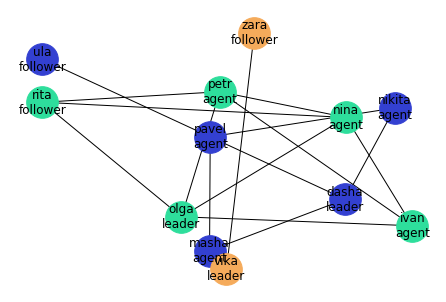

<Figure size 3600x3600 with 0 Axes>

In [96]:
import networkx as nx
import matplotlib.pyplot as plt
import random

def rand_color():
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())



COLORS=['r','b','g']
for idx, items in LABELED_ITEMS.items():
    G=nx.Graph(directed=True)
    # add nodes            
    for node, label in items['labels'].items():
        G.add_node(node + '\n' + label)

    # add edges
    for edge in items['edges']:
        G.add_edge(edge[0] +'\n' + items['labels'][edge[0]], edge[1]+'\n' + items['labels'][edge[1]])

    nx.draw(G, pos=None, node_color=rand_color(), arrows=True, with_labels=True, node_size=1000)

# show graph
plt.figure(figsize=(50, 50))
plt.show()
#done